# The telescope observations

Authors: Stefano Mandelli, ...

In this notebook tutorial we present the `pycal` package. This package was conceived for simulating the atmospheric noise, in particular the correlated noise introduced by the water vapor structures. Differently from the oxygen, the water vapor is not well mixed in the atmosphere and its distribution follow the Kolmogorov spectrum. These strucures are seen by the telescope during the observations and, in the time-frequency domain are very dificult to identify. The features of this noise are very similar to the scientific signal and is very difficult to get rid of it, whitout a significan loss of scientific information.

In this tutorial I present a possibile way to assess the atmospheric noise of a specific geografical site, in order to create noise model that can be used as preconditioner during the map-making operations.

In [21]:
# import system packages
import os
from datetime import datetime
import sys
import argparse
import traceback
import pickle
import yaml

# import numpy
import numpy as np
import healpy as hp
%matplotlib inline

# the MPI comunicator class, customized for pycal data storage
from pycal.mpi import get_world, Comm

# the Data class 
from pycal.dist import distribute_uniform, Data

# some pycal utils to share informations with the environment
from pycal.utils import Logger, Environment, memreport

# some timers
from pycal.timing import function_timer, GlobalTimers, Timer, gather_timers
from pycal.timing import dump as dump_timing

# the simulate the pointing, the atmosphere and put all the information in the TODGround class
from pycal.todmap import TODGround, OpSimAtmosphere, OpPointingHpix
from pycal.weather import Weather

# Some wrapper to libaatm, they solve the radiative transfer equation in local thermodynamic equilibrium
from pycal.todmap.atm import atm_absorption_coefficient, atm_absorption_coefficient_vec

# helper functions
from pycal.tests._helpers import boresight_focalplane
import pycal.qarray as qa

# focal plane and telescope calsses
from pycal.todmap import Focalplane
from pycal.todmap import Telescope

In [9]:
# set up the output directory for each mc iterations

@function_timer
def setup_output(outdir, comm, mc, freq):
    outpath = "{}/{:08}/{:03}".format(outdir, mc, int(freq))
    if comm.world_rank == 0:
        os.makedirs(outpath, exist_ok=True)
    return outpath

In [10]:
# we start to load a fake focal plane. In this way it is possible to see the structure of the Focalplane class


In [11]:
def load_focalplane(args, comm):
    focalplane = None

    # Load focalplane information

    if comm.comm_world is None or comm.comm_world.rank == 0:
        if args.focalplane is None:
            detector_data = {}
            with open(r'/home/algebrato/.julia/dev/Stripeline/instrumentdb/strip_focal_plane.yaml') as file:
                focalplane=yaml.full_load(file)

            detecotrs=focalplane['horns'].keys()
            for i in detecotrs:
                directions=focalplane['horns'][i]['orientation']
                l=np.arctan(directions[0]/directions[2])
                u=np.arctan(directions[1]/directions[2])
                zaxis = np.array([0, 0, 1], dtype=np.float64)
                
                angrot = qa.rotation(zaxis, 0 * np.pi / 180.0)
                wx = np.rad2deg(l) * np.pi / 180.0
                wy = np.rad2deg(u) * np.pi / 180.0
                wz = np.sqrt(1.0 - (wx * wx + wy * wy))
                wdir = np.array([wx, wy, wz])
                strip_quat = qa.from_vectors(zaxis, wdir)
                
                strip = {}
                strip["quat"] = strip_quat
                strip["fwhm"] = 20.0
                strip["fknee"] = 0.0
                strip["fmin"] = 1e-9
                strip["alpha"] = 1.0
                strip["NET"] = 1.0
                strip["color"] = "r"
            
                detector_data[i] = strip
            
            focalplane = Focalplane(
                detector_data=detector_data, sample_rate=args.sample_rate
            )
        else:
            focalplane = Focalplane(
                fname_pickle=args.focalplane, sample_rate=args.sample_rate
            )
    if comm.comm_world is not None:
        focalplane = comm.comm_world.bcast(focalplane, root=0)

    if args.debug:
        if comm.comm_world is None or comm.comm_world.rank == 0:
            outfile = "{}/focalplane.png".format(args.outdir)
            focalplane._plot_fp(12, 12, outfile)

    #schedule.telescope.focalplane = focalplane
    #detweights = focalplane.detweights

    return focalplane

In [12]:
# definition of the logger, the global timer and the environment
log = Logger.get()
gt = GlobalTimers.get()
env = Environment.get()

gt.start("Atmospheric simulation (globbal timer)")
timer0 = Timer()
timer0.start()

# Get the communicator
mpiworld, procs, rank = get_world()
if rank == 0:
    print(env)
if mpiworld is None:
    log.info("Running serially with one process at {}".format(str(datetime.now())))
else:
    if rank == 0:
        log.info(
            "Running with {} processes at {}".format(procs, str(datetime.now()))
        )
comm = Comm(world=mpiworld)

<cal.Environment
  Source code version = 0.0.0
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 12
  MPI build enabled
  MPI runtime enabled
>


In [13]:
# Arguments of the simulation
class args:
    sample_rate=20
    focalplane=None
    ces_name = "Test1"
    scan="spin"
    subscan="spin_1day"
    ces_stop_time = 60*60*24
    ces_start_time = 0
    sample_rate = 20
    site_name= "Tenerife"
    site_lon = "-16:31:00"
    site_lat = "28:20:00"
    site_alt = 2390.0
    coord = "C"
    ces_azmin = 0
    ces_azmax = 0
    ces_el = 70
    scanrate = 1.0
    scan_accel = 3.0
    CES_start = None
    NSIDE=256
    debug=True
    outdir="out_directory"
args = args()

In [14]:
fp = load_focalplane(args, comm)

In [15]:
# Create the TOD structure
data = Data(comm)
weather = "weather_STRIP.fits"
totsamples = int((args.ces_stop_time - args.ces_start_time) * args.sample_rate)

In [16]:
# create the TOD for this observation
if comm.comm_group is not None:
    ndetrank = comm.comm_group.size
else:
    ndetrank = 1

try:
    tod = TODGround(
        comm.comm_group,
        fp.detquats,
        totsamples,
        detranks=ndetrank,
        firsttime=args.ces_start_time,
        rate=args.sample_rate,
        site_lon=args.site_lon,
        site_lat=args.site_lat,
        site_alt=args.site_alt,
        azmin=args.ces_azmin,
        azmax=args.ces_azmax,
        el=args.ces_el,
        scanrate=args.scanrate,
        scan_accel=args.scan_accel,
        sinc_modulation=None,
        CES_start=None,
        CES_stop=None,
        sun_angle_min=None,
        coord=args.coord,
        sampsizes=None,
        report_timing=None,
        hwprpm=None,
        hwpstep=None,
        hwpsteptime=None,
    )
except RuntimeError as e:
    raise RuntimeError(
        'Failed to create TOD for {}-{}-{}: "{}"'
        "".format(args.ces_name, args.scan, args.subscan, e)
    )

# Create the observation, and append the tod
obs = {}
obs["name"] = "CES-{}-{}-{}-{}".format(
    args.site_name, args.ces_name, args.scan, args.subscan
)
obs["tod"] = tod
obs["id"] = data.comm.group
obs["telescope_id"] = 1
obs["site"] = "Tenerife"
obs["site_name"] = args.site_name
obs["site_id"] = 123
obs["altitude"] = args.site_alt
obs["weather"] = Weather(weather, site=123)
obs["fpradius"] = 10.0
obs["start_time"] = args.ces_start_time
obs["focalplane"] = fp

data.obs.append(obs)

In [17]:
data.obs

[{'name': 'CES-Tenerife-Test1-spin-spin_1day',
  'tod': <TODGround
    55 total detectors and 1728000 total samples
    Using MPI communicator <mpi4py.MPI.Intracomm object at 0x7f4521988270>
      In grid dimensions 1 sample ranks x 1 detranks
    Process at (0, 0) in grid has data for:
      Samples 0 - 1727999 (inclusive)
      Detectors:
        B0
        B1
        B2
        B3
        B4
        B5
        B6
        G0
        G1
        G2
        G3
        G4
        G5
        G6
        I0
        I1
        I2
        I3
        I4
        I5
        I6
        O0
        O1
        O2
        O3
        O4
        O5
        O6
        R0
        R1
        R2
        R3
        R4
        R5
        R6
        V0
        V1
        V2
        V3
        V4
        V5
        V6
        W1
        W2
        W3
        W4
        W5
        W6
        Y0
        Y1
        Y2
        Y3
        Y4
        Y5
        Y6
      Cache contains 139968000 bytes
  >,
  'id': 0,

In [18]:
# Expand the pointing, interpolating the quaternions
if comm.comm_world is not None:
    comm.comm_world.barrier()
timer0.stop()
if comm.world_rank == 0:
    timer0.report("Simulated scans")

if comm.world_rank == 0:
    log.info("Expanding pointing")

pointing = OpPointingHpix(
    nside=128,
    nest=True,
    mode="IQU",
    single_precision=1e-7,
    nside_submap=128,
)

pointing.exec(data)

if comm.comm_world is not None:
    comm.comm_world.barrier()
if comm.world_rank == 0:
    timer0.report_clear("Pointing generation")

In [19]:
# Atmospheric MC simulation 
start_mc = 0
nsimu = 1
cache_name = "atm"
atm_cache="atm_cache"
verbose = 0
freq = 43 # GHz

for mc in range(start_mc, start_mc + nsimu):

    log = Logger.get()
    tmr = Timer()
    tmr.start()
    if comm.world_rank == 0 and verbose:
        log.info("Simulating atmosphere")
        if atm_cache and not os.path.isdir(atm_cache):
            try:
                os.makedirs(atm_cache)
            except FileExistsError:
                pass

    common_atm_params = {
    "realization": mc,
    "component": 123456,
    "lmin_center": 0.01,
    "lmin_sigma": 0.001,
    "lmax_center": 10,
    "lmax_sigma": 10,
    "zatm": 40000.0,
    "zmax": 2000.0,
    "xstep": 100.0,
    "ystep": 100.0,
    "zstep": 100.0,
    "nelem_sim_max": 10000,
    "verbosity": 0,
    "gain": 1,
    "z0_center": 2000,
    "z0_sigma": 0,
    "apply_flags": False,
    "common_flag_name": None,
    "common_flag_mask": 255,
    "flag_name": None,
    "flag_mask": 255,
    "report_timing": True,
    "wind_dist": 10000,
    "flush": False,
    }

    # Simulate the atmosphere signal
    atm = OpSimAtmosphere(out="atm", cachedir=atm_cache, freq=freq, **common_atm_params)
    atm.exec(data)

    if comm.comm_world is not None:
        comm.comm_world.barrier()
    tmr.stop()
    if comm.world_rank == 0:
        tmr.report("Atmosphere simulation")


    if comm.world_rank == 0:
            log.info(
                "Processing frequency {}GHz, MC = {}".format(freq, mc))

Creating atm_cache/0/0/0


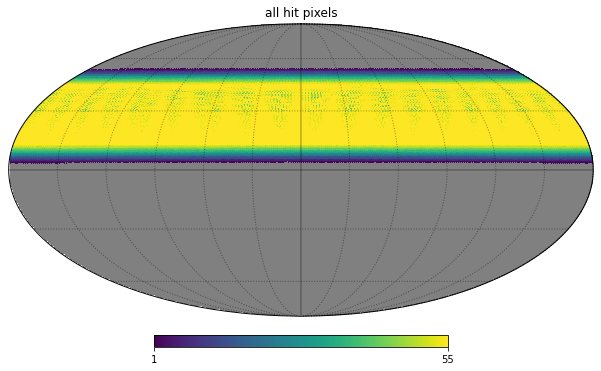

In [25]:
npix = 12 * 128 ** 2
hitmap = np.zeros(npix)

for obs in data.obs:
    tod = obs['tod']
    for det in tod.local_dets:
        pixels = tod.cache.reference("pixels_{}".format(det))
        hitmap[pixels] += 1
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, nest=True, title="all hit pixels", cbar=True)
hp.graticule(alpha=0.4)

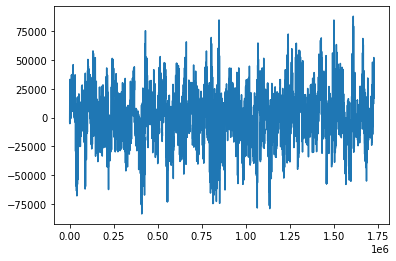

In [23]:
import pylab as plt
plt.plot(data.obs[0]['tod'].cache.reference(name='atm_I0'))

In [26]:
obs

{'name': 'CES-Tenerife-Test1-spin-spin_1day',
 'tod': <TODGround
   55 total detectors and 1728000 total samples
   Using MPI communicator <mpi4py.MPI.Intracomm object at 0x7f4521988270>
     In grid dimensions 1 sample ranks x 1 detranks
   Process at (0, 0) in grid has data for:
     Samples 0 - 1727999 (inclusive)
     Detectors:
       B0
       B1
       B2
       B3
       B4
       B5
       B6
       G0
       G1
       G2
       G3
       G4
       G5
       G6
       I0
       I1
       I2
       I3
       I4
       I5
       I6
       O0
       O1
       O2
       O3
       O4
       O5
       O6
       R0
       R1
       R2
       R3
       R4
       R5
       R6
       V0
       V1
       V2
       V3
       V4
       V5
       V6
       W1
       W2
       W3
       W4
       W5
       W6
       Y0
       Y1
       Y2
       Y3
       Y4
       Y5
       Y6
     Cache contains 2515968000 bytes
 >,
 'id': 0,
 'telescope_id': 1,
 'site': 'Tenerife',
 'site_name': 'Tenerife

In [27]:
log = Logger.get()
if comm.world_rank == 0 and verbose:
    log.info("Scaling atmosphere by frequency")
timer = Timer()
timer.start()
for obs in data.obs: # Now we have only one observation
    tod = obs["tod"]
    todcomm = tod.mpicomm

    weather = obs["weather"]
    focalplane = obs["focalplane"]

    start_time = obs["start_time"]
    weather.set(123, mc, start_time)
    altitude = obs["altitude"]
    air_temperature = weather.air_temperature
    surface_pressure = weather.surface_pressure
    pwv = weather.pwv
    # Use the entire processing group to sample the absorption
    # coefficient as a function of frequency
    freqmin = 0
    freqmax = 2 * freq
    nfreq = 1001
    freqstep = (freqmax - freqmin) / (nfreq - 1)
    if todcomm is None:
        nfreq_task = nfreq
        my_ifreq_min = 0
        my_ifreq_max = nfreq
    else:
        nfreq_task = int(nfreq // todcomm.size) + 1
        my_ifreq_min = nfreq_task * todcomm.rank
        my_ifreq_max = min(nfreq, nfreq_task * (todcomm.rank + 1))
    my_nfreq = my_ifreq_max - my_ifreq_min
    my_freqs = freqmin + np.arange(my_ifreq_min, my_ifreq_max) * freqstep
    my_absorption = atm_absorption_coefficient_vec(
                altitude,
                air_temperature,
                surface_pressure,
                pwv,
                my_freqs[0],
                my_freqs[-1],
                my_nfreq,
            )
    
    if todcomm is None:
        freqs = my_freqs
        absorption = my_absorption
    else:
        freqs = np.hstack(todcomm.allgather(my_freqs))
        absorption = np.hstack(todcomm.allgather(my_absorption))

    for det in tod.local_dets:
        try:
            # Use detector bandpass from the focalplane
            center = focalplane[det]["bandcenter_ghz"]
            width = focalplane[det]["bandwidth_ghz"]
        except Exception:
            # Use default values for the entire focalplane
            center = freq
            width = 0.2 * freq
        nstep = 101
        # Interpolate the absorption coefficient to do a top hat
        # integral across the bandpass
        det_freqs = np.linspace(center - width / 2, center + width / 2, nstep)
        absorption_det = np.mean(np.interp(det_freqs, freqs, absorption))
        cachename = "{}_{}".format(cache_name, det)
        print("{}_{}".format(cache_name, det))
        ref = tod.cache.reference(cachename)
        ref *= absorption_det
        del ref

if comm.comm_world is not None:
    comm.comm_world.barrier()
timer0.stop()
if comm.world_rank == 0 and verbose:
    timer0.report("Atmosphere scaling")

atm_B0
atm_B1
atm_B2
atm_B3
atm_B4
atm_B5
atm_B6
atm_G0
atm_G1
atm_G2
atm_G3
atm_G4
atm_G5
atm_G6
atm_I0
atm_I1
atm_I2
atm_I3
atm_I4
atm_I5
atm_I6
atm_O0
atm_O1
atm_O2
atm_O3
atm_O4
atm_O5
atm_O6
atm_R0
atm_R1
atm_R2
atm_R3
atm_R4
atm_R5
atm_R6
atm_V0
atm_V1
atm_V2
atm_V3
atm_V4
atm_V5
atm_V6
atm_W1
atm_W2
atm_W3
atm_W4
atm_W5
atm_W6
atm_Y0
atm_Y1
atm_Y2
atm_Y3
atm_Y4
atm_Y5
atm_Y6


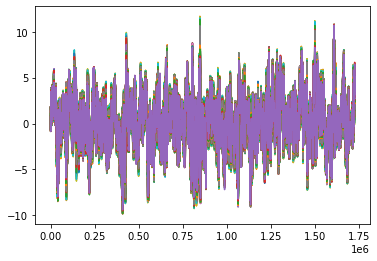

In [28]:
for det in obs['tod'].local_dets:
    plt.plot(obs['tod'].cache.reference("atm_{}".format(det))/1e3)

In [29]:
log = Logger.get()
if comm.world_rank == 0 and verbose:
    log.info("Updating atmospheric noise weights")
timer = Timer()
timer.start()

site_id = obs["site_id"]
weather = obs["weather"]
start_time = obs["start_time"]
weather.set(site_id, mc, start_time)
altitude = obs["altitude"]
absorption = atm_absorption_coefficient(
    altitude,
    weather.air_temperature,
    weather.surface_pressure,
    weather.pwv,
    freq,
)
obs["noise_scale"] = absorption * weather.air_temperature

if comm.comm_world is not None:
    comm.comm_world.barrier()
timer.stop()
if comm.world_rank == 0 and verbose:
    timer.report("Atmosphere weighting")



In [30]:
# Set up the output directory
mcoffset = freq * 1000000
outpath = setup_output(args.outdir, comm, mc + mcoffset, freq)

In [31]:
gt.stop_all()
if mpiworld is not None:
    mpiworld.barrier()  
timer = Timer()
timer.start()
alltimers = gather_timers(comm=mpiworld)
if comm.world_rank == 0:
    out = os.path.join(args.outdir, "timing")
    dump_timing(alltimers, out)
    timer.stop()
    timer.report("Gather and dump timing info")
    timer0.report_clear("single_module_simulation.py")

In [32]:
hitmap

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

In [39]:
npix = 12 * 128 ** 2
mappa = np.zeros(npix)

for obs in data.obs:
    tod = obs['tod']
    for det in tod.local_dets:
        pixels = tod.cache.reference("pixels_{}".format(det))
        signal = tod.cache.reference("atm_{}".format(det))
        mappa[pixels] +=signal
mappa = (mappa / (hitmap))/1e3
mappa[mappa == 0 ] = hp.UNSEEN

<Figure size 1080x1080 with 0 Axes>

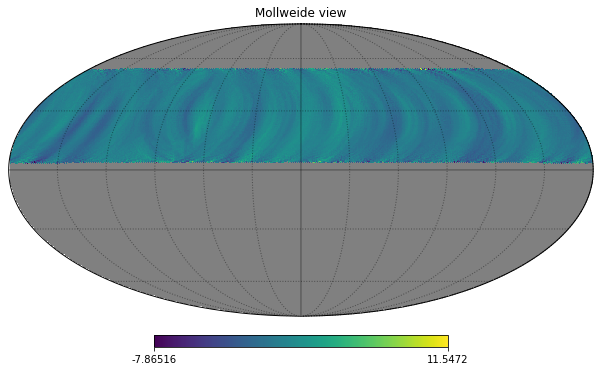

In [40]:
plt.figure(figsize=(15,15))
hp.mollview(mappa, nest=True)
hp.graticule(alpha=0.4)

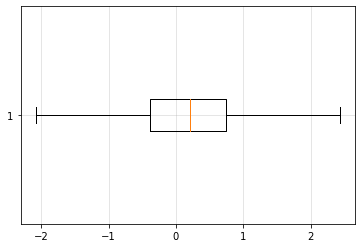

In [43]:
plt.boxplot(mappa[mappa > hp.UNSEEN], vert=False, showfliers=False)
plt.grid(alpha=0.4)

In [51]:
tod_matrix=dict()
for obs in data.obs:
    tod = obs['tod']
    for det in tod.local_dets:
        tod_matrix[det]=obs['tod'].cache.reference("atm_{}".format(det))
        



In [52]:
import pandas as pd

matrix = pd.DataFrame(tod_matrix)
matrix.to_csv(r"TOD_matrix.csv",index = False, header=True)

MTX_CX=matrix.corr()

[Text(0.5, 186.89999999999995, 'Detectors name'),
 Text(114.0, 0.5, 'Detectors name'),
 Text(0.5, 1.0, 'Correlation Level')]

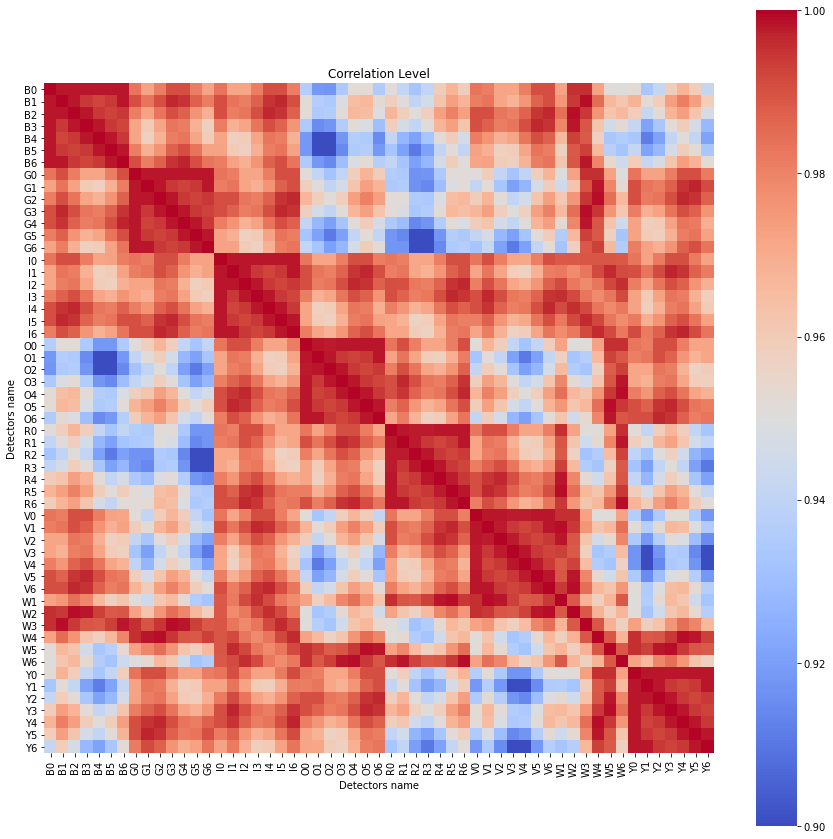

In [63]:
import seaborn as sns

plt.figure(figsize=(15,15))
ax = sns.heatmap(MTX_CX, annot=False, cmap='coolwarm', vmin=0.9, vmax=1, center=0.95, square=True)
ax.set(xlabel='Detectors name', ylabel='Detectors name', title="Correlation Level")



In [75]:
from scipy.signal import periodogram as peridog

In [128]:
power = np.zeros(int(len(tod_matrix["I0"])/2 + 1 ))

for i in tod_matrix:
    f, p = peridog(tod_matrix[i], fs=20)
    power += p
    

(0.1, 100000000000.0)

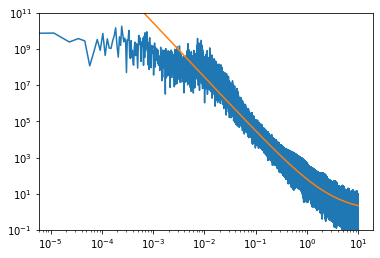

In [127]:
plt.loglog(f, power/(49+6), '-')
plt.loglog(f, 1*(((1+3/f))**(9/3)))

plt.ylim(1e-1, 1e11)